In [11]:
robust_scaler_file = "../model/robust_scaler"
cate_hist_file = "../model/cate_hist"
xgb_model_file = "../model/xgb_model"
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle


def rmse(y_true, y_predict):
    return mean_squared_error(y_true, y_predict)**0.5

def kfoldcross(k, df_data, random_state = 51):
    result = []
    df_clone = df_data.copy()
    for i in range(0,k):
        df_i = df_data.sample(frac=1/(k-i),random_state=random_state)
        df_data = df_data.drop(df_i.index)
        train_i = df_clone.drop(df_i.index)
        result.append((df_i, train_i))
    return result

def histogram(data, bins = None):
    if bins == None:
        bins = list(set(data))
    data_dict = {v: 0 for v in bins}
    data_dict['other'] = 0
    for v in data:
        if v in data_dict:
            data_dict[v] += 1
        else:
            data_dict['other'] += 1
    for k in data_dict:
        data_dict[k] = data_dict[k]/len(data)
    return data_dict

from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
import pandas as pd
data_file = '../data/Duration_dataset.csv'
df = pd.read_csv(data_file)
df.tail()

,ID,Product Category,Inspected Samples,Measurement Samples,Workmanship Samples,Number of Item type,Number of Styles,Total Time (H)
393,393,Tee,125,0,0,54,2,3.071944
394,394,Boots,80,0,0,10,1,1.672778
395,395,Pants,32,0,0,18,2,1.406111
396,396,Jeans,32,0,0,22,2,1.930556
397,397,Legging,125,0,0,21,1,3.994722


In [12]:
# Get feature from Product Category
def preprocessCategory(cat_str):
    cat_rst = cat_str.lower()
    cat_array = cat_rst.split(',')
    cat_result = []
    for v in cat_array:
        v = v.strip()
        v = v.rstrip('s')
        if 'boot' in v:
            v = 'boot'
        elif 'tee' in v:
            v = 'tee'
        elif 'crew' in v:
            v = 'crew'
        cat_result.append(v)
    return cat_result[0]

df['Product Category'] = df['Product Category'].apply(preprocessCategory)
cate_hist = histogram(df['Product Category'])
pickle.dump(cate_hist, open(cate_hist_file, "wb"))
df['Product Category'] = df['Product Category'].apply(lambda k: cate_hist[k] if k in cate_hist else 0)

In [13]:
len(cate_hist)

54

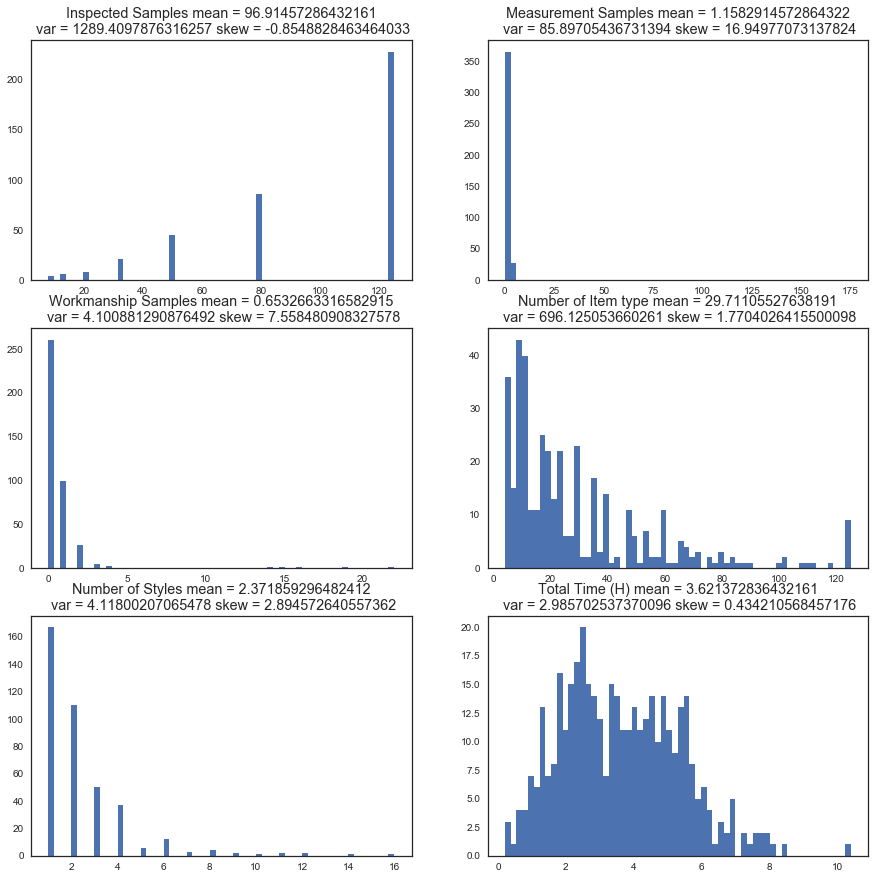

In [14]:
from scipy.stats import kurtosis
from scipy.stats import skew
import numpy as np
import matplotlib.pyplot as plt

f, ([ax1, ax2],[ ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(15, 15))

plt.style.use('ggplot')

data = df['Inspected Samples']
ax1.hist(df['Inspected Samples'], bins= 60)
ax1.set_title('Inspected Samples mean = ' +  str(np.mean(data)) + 
              '\n var = ' + str(np.var(data)) + ' skew = ' + str(skew(data)))

data = df['Measurement Samples']
ax2.hist(df['Measurement Samples'], bins= 60)
ax2.set_title('Measurement Samples mean = ' +  str(np.mean(data)) + 
              '\n var = ' + str(np.var(data)) + ' skew = ' + str(skew(data)))

data = df['Workmanship Samples']
ax3.hist(df['Workmanship Samples'], bins= 60)
ax3.set_title('Workmanship Samples mean = ' +  str(np.mean(data)) + 
              '\n var = ' + str(np.var(data)) + ' skew = ' + str(skew(data)))

data = df['Number of Item type']

ax4.hist(df['Number of Item type'], bins= 60)
ax4.set_title('Number of Item type mean = ' +  str(np.mean(data)) + 
              '\n var = ' + str(np.var(data)) + ' skew = ' + str(skew(data)))

data = df['Number of Styles']

ax5.hist(df['Number of Styles'], bins= 60)
ax5.set_title('Number of Styles mean = ' +  str(np.mean(data)) + 
              '\n var = ' + str(np.var(data)) + ' skew = ' + str(skew(data)))

data = df['Total Time (H)']
ax6.hist(df['Total Time (H)'], bins= 60)
ax6.set_title('Total Time (H) mean = ' +  str(np.mean(data)) + 
              '\n var = ' + str(np.var(data)) + ' skew = ' + str(skew(data)))
plt.show()

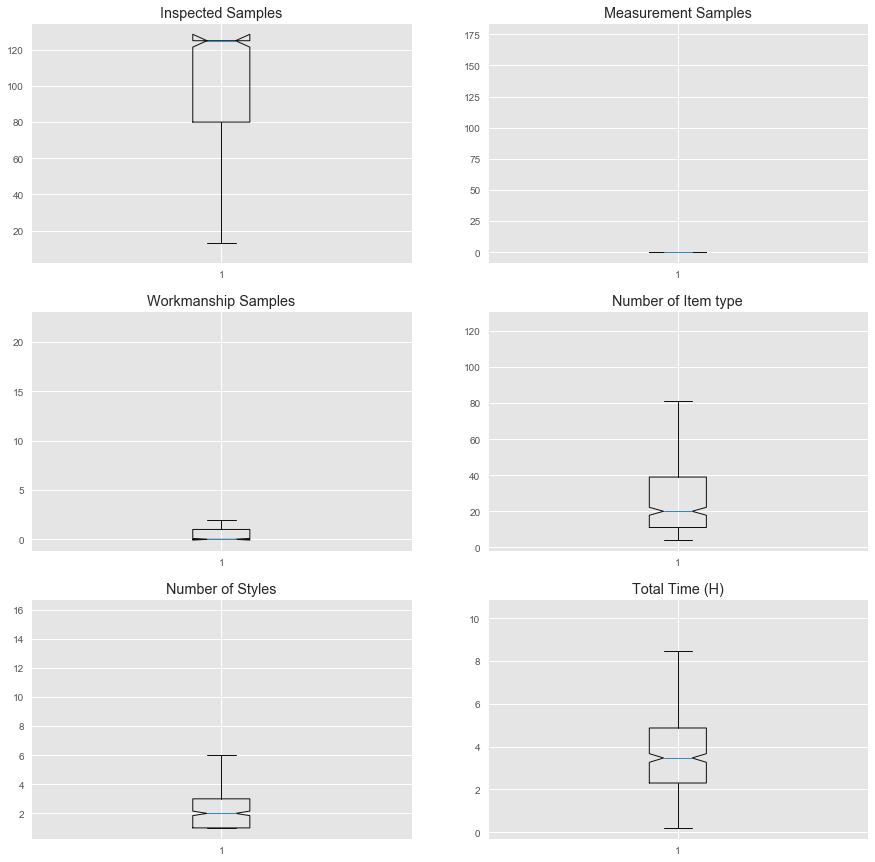

In [15]:
f, ([ax1, ax2],[ ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(15, 15))

plt.style.use('ggplot')

ax1.boxplot(df['Inspected Samples'], notch= 1, sym='+', vert=1, whis=1.5)
ax1.set_title('Inspected Samples')

ax2.boxplot(df['Measurement Samples'],  notch= 1, sym='+', vert=1, whis=1.5)
ax2.set_title('Measurement Samples')

ax3.boxplot(df['Workmanship Samples'],  notch= 1, sym='+', vert=1, whis=1.5)
ax3.set_title('Workmanship Samples')


ax4.boxplot(df['Number of Item type'],  notch= 1, sym='+', vert=1, whis=1.5)
ax4.set_title('Number of Item type')


ax5.boxplot(df['Number of Styles'],  notch= 1, sym='+', vert=1, whis=1.5)
ax5.set_title('Number of Styles')


ax6.boxplot(df['Total Time (H)'],  notch= 1, sym='+', vert=1, whis=1.5)
ax6.set_title('Total Time (H)')

plt.show()

In [16]:
# detect outlier
from sklearn.preprocessing import RobustScaler
rbscaler = RobustScaler(with_centering=False, with_scaling=False)

outlier_features = ['Inspected Samples','Workmanship Samples','Measurement Samples',
                  'Number of Item type','Number of Styles']

rbscaler = RobustScaler(with_centering=False, with_scaling=False)
df[outlier_features] = rbscaler.fit_transform(df[outlier_features])
# df['Measurement Samples'] = df['Measurement Samples'].apply(lambda v: v if v in [0,1,2,3,4,5] else 6)
# save RobustScaler
pickle.dump(rbscaler, open(robust_scaler_file, "wb"))
Q1 = df['Total Time (H)'].describe()['25%']
Q3 = df['Total Time (H)'].describe()['75%']
outfence = 1.5*(Q3 - Q1) + Q3
df = df[df['Total Time (H)'] < outfence]

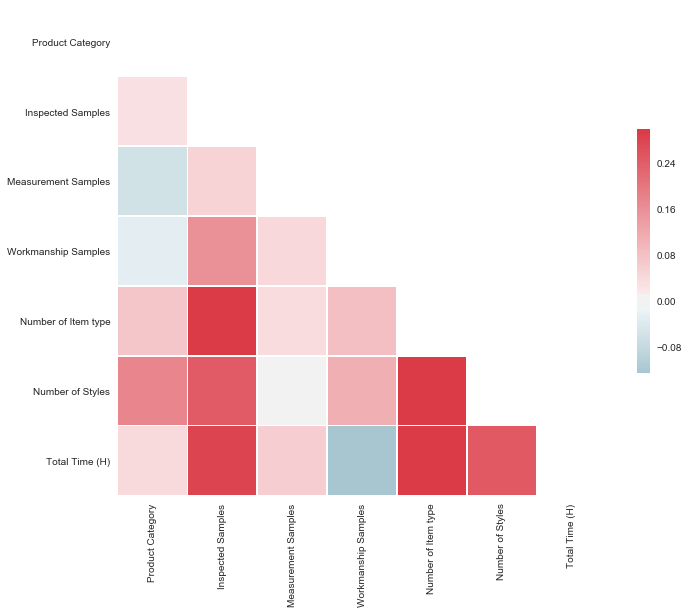

Product Category       0.039840
Inspected Samples      0.283308
Measurement Samples    0.058796
Workmanship Samples   -0.126924
Number of Item type    0.354059
Number of Styles       0.249405
Total Time (H)         1.000000
Name: Total Time (H), dtype: float64

In [17]:
import seaborn as sns
df = df.drop('ID',axis = 1)
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
corr['Total Time (H)']

In [18]:
df_5_array = kfoldcross(5, df)

RMSE_train = 1.5511022083683232
R2_train = 0.16156511355290648
RMSE = 1.567213528310304
R2 = 0.11475050476646745


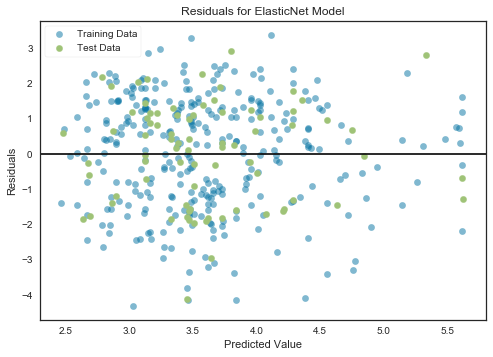

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn import preprocessing
regr = ElasticNet(random_state=0)
input_cols = ['Product Category','Inspected Samples', 'Measurement Samples',
              'Workmanship Samples', 'Number of Item type', 'Number of Styles']
output_col = 'Total Time (H)'

RMSE = 0
R2 = 0
RMSE_train = 0
R2_train = 0
for (df_test, df_train) in df_5_array:
    X_train = df_train[input_cols].copy()
    y_train = df_train[output_col].copy()
    
    X_test = df_test[input_cols].copy()
    y_test = df_test[output_col].copy()

    regr.fit(X_train, y_train)
    y_pre = regr.predict(X_test)
    y_pre_train = regr.predict(X_train)
    RMSE_train += rmse(y_train, y_pre_train)
    R2_train += r2_score(y_train, y_pre_train)
    
    RMSE += rmse(y_test, y_pre)
    R2 += r2_score(y_test, y_pre)

RMSE_train = RMSE_train/len(df_5_array)
R2_train = R2_train/len(df_5_array)

RMSE = RMSE/len(df_5_array)
R2 = R2/len(df_5_array)
print ("RMSE_train = " + str(RMSE_train))
print ("R2_train = " + str(R2_train))

print ("RMSE = " + str(RMSE))
print ("R2 = " + str(R2))

visualizer = ResidualsPlot(regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

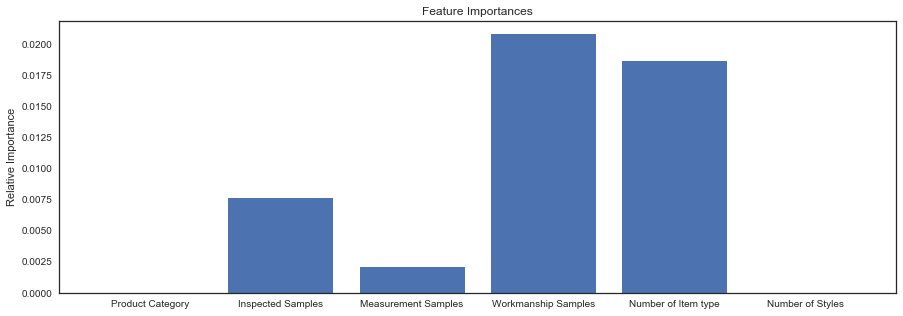

In [20]:
plt.subplots(figsize=(15, 5))
plt.title('Feature Importances')
plt.bar(range(len(input_cols)), abs(regr.coef_), align='center')
plt.xticks(range(len(input_cols)), input_cols)
plt.ylabel('Relative Importance')
plt.show()

RMSE_train = 1.59297637077266
R2_train = 0.45851390737347764
RMSE = 1.4698899308306785
R2 = 0.2180833437959529


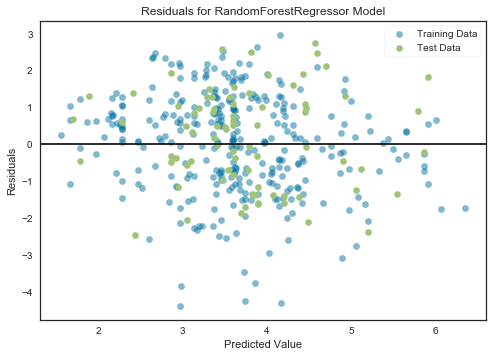

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
randomforest_regr = RandomForestRegressor(max_depth= 4, random_state=10)
RMSE = 0
R2 = 0

for (df_test, df_train) in df_5_array:
    X_train = df_train[input_cols].copy()
    y_train = df_train[output_col].copy()
    
    X_test = df_test[input_cols].copy()
    y_test = df_test[output_col].copy()

    
    randomforest_regr.fit(X_train.values, y_train.values)
    y_pre = randomforest_regr.predict(X_test.values)
    y_pre_train = randomforest_regr.predict(X_train.values)
    
    RMSE_train += rmse(y_train.values, y_pre_train)
    R2_train += r2_score(y_train.values, y_pre_train)
    
    RMSE += rmse(y_test.values, y_pre)
    R2 += r2_score(y_test.values, y_pre)

RMSE_train = RMSE_train/len(df_5_array)
R2_train = R2_train/len(df_5_array)

RMSE = RMSE/len(df_5_array)
R2 = R2/len(df_5_array)
print ("RMSE_train = " + str(RMSE_train))
print ("R2_train = " + str(R2_train))

print ("RMSE = " + str(RMSE))
print ("R2 = " + str(R2))

visualizer = ResidualsPlot(randomforest_regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

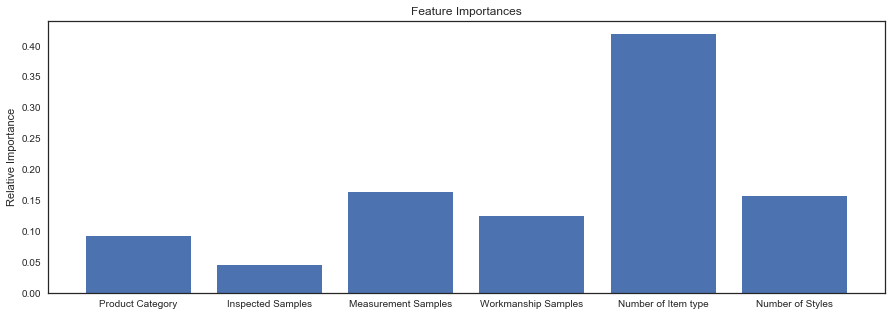

In [22]:
plt.subplots(figsize=(15, 5))
plt.title('Feature Importances')
plt.bar(range(len(input_cols)), randomforest_regr.feature_importances_, align='center')
plt.xticks(range(len(input_cols)), input_cols)
plt.ylabel('Relative Importance')
plt.show()

RMSE_train = 1.457064559784719
R2_train = 0.6398904094352199
RMSE = 1.4224249743540391
R2 = 0.26374925434200647


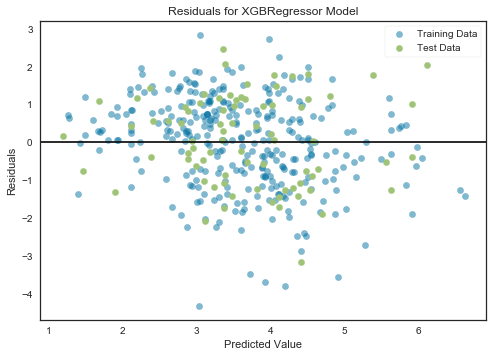

In [23]:
from sklearn import preprocessing
from xgboost import XGBRegressor
xgd = XGBRegressor(max_depth = 3, learning_rate=0.1, 
                       objective = 'reg:linear', 
                       n_estimators= 50)
RMSE = 0
R2 = 0
for (df_test, df_train) in df_5_array:
    X_train = df_train[input_cols].copy()
    y_train = df_train[output_col].copy()
    
    X_test = df_test[input_cols].copy()
    y_test = df_test[output_col].copy()
 
    xgd.fit(X_train.values, y_train.values)
    y_pre = xgd.predict(X_test.values)
    y_pre_train = xgd.predict(X_train.values)
    RMSE_train += rmse(y_train.values, y_pre_train)
    R2_train += r2_score(y_train.values, y_pre_train)
    
    RMSE += rmse(y_test.values, y_pre)
    R2 += r2_score(y_test.values, y_pre)

RMSE_train = RMSE_train/len(df_5_array)
R2_train = R2_train/len(df_5_array)

RMSE = RMSE/len(df_5_array)
R2 = R2/len(df_5_array)
print ("RMSE_train = " + str(RMSE_train))
print ("R2_train = " + str(R2_train))

print ("RMSE = " + str(RMSE))
print ("R2 = " + str(R2))

visualizer = ResidualsPlot(xgd)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [24]:
input_cols = ['Product Category','Inspected Samples', 'Measurement Samples', 'Workmanship Samples'
              , 'Number of Item type', 'Number of Styles']

from sklearn import preprocessing
from xgboost import XGBRegressor
xgd_final = XGBRegressor(max_depth = 3, learning_rate=0.1, 
               objective = 'reg:linear', subsample = 1.0,
               colsample_bytree = 0.9, colsample_bylevel = 0.6,
               n_estimators= 300, reg_lambda = 101.)

RMSE = 0
R2 = 0
RMSE_train = 0
R2_train = 0
r2_list = []
rmse_list = []
model_list = []

df_5_array = kfoldcross(5, df, random_state = 49)
df_test, df_train = df_5_array[4]

X_train = df_train[input_cols].copy()
y_train = df_train[output_col].copy()

X_test = df_test[input_cols].copy()
y_test = df_test[output_col].copy()

eval_set = [(X_test.values, y_test.values)]
xgd_final.fit(X_train.values, y_train.values, eval_set=eval_set, 
        verbose=True,early_stopping_rounds= 10 , eval_metric="rmse")

y_pre = xgd_final.predict(X_test.values)
y_pre_train = xgd_final.predict(X_train.values)
RMSE_train = rmse(y_train.values, y_pre_train)
R2_train = r2_score(y_train.values, y_pre_train)

RMSE = rmse(y_test.values, y_pre)
R2 = r2_score(y_test.values, y_pre)



print ("RMSE_train = " + str(RMSE_train))
print ("R2_train = " + str(R2_train))

print ("RMSE = " + str(RMSE))
print ("R2 = " + str(R2))
pickle.dump(xgd_final, open(xgb_model_file, "wb"))

[0]	validation_0-rmse:3.09551
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.91117
[2]	validation_0-rmse:2.74581
[3]	validation_0-rmse:2.5981
[4]	validation_0-rmse:2.46672
[5]	validation_0-rmse:2.34892
[6]	validation_0-rmse:2.24631
[7]	validation_0-rmse:2.15481
[8]	validation_0-rmse:2.07632
[9]	validation_0-rmse:2.00833
[10]	validation_0-rmse:1.94722
[11]	validation_0-rmse:1.8943
[12]	validation_0-rmse:1.84726
[13]	validation_0-rmse:1.80774
[14]	validation_0-rmse:1.77165
[15]	validation_0-rmse:1.73619
[16]	validation_0-rmse:1.7037
[17]	validation_0-rmse:1.66999
[18]	validation_0-rmse:1.64776
[19]	validation_0-rmse:1.62492
[20]	validation_0-rmse:1.60296
[21]	validation_0-rmse:1.58304
[22]	validation_0-rmse:1.56605
[23]	validation_0-rmse:1.54708
[24]	validation_0-rmse:1.53149
[25]	validation_0-rmse:1.51608
[26]	validation_0-rmse:1.5012
[27]	validation_0-rmse:1.48972
[28]	validation_0-rmse:1.47915
[29]	validation_0-rmse:1.47013
[30]	validation_0-r

In [25]:
xgd_final.feature_importances_

array([0.249, 0.103, 0.078, 0.144, 0.261, 0.165], dtype=float32)

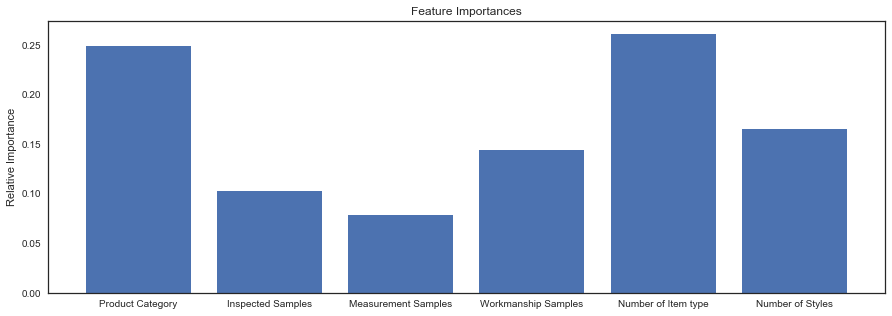

In [26]:
plt.subplots(figsize=(15, 5))
plt.title('Feature Importances')
plt.bar(range(len(input_cols)), xgd_final.feature_importances_, align='center')
plt.xticks(range(len(input_cols)), input_cols)
plt.ylabel('Relative Importance')
plt.show()

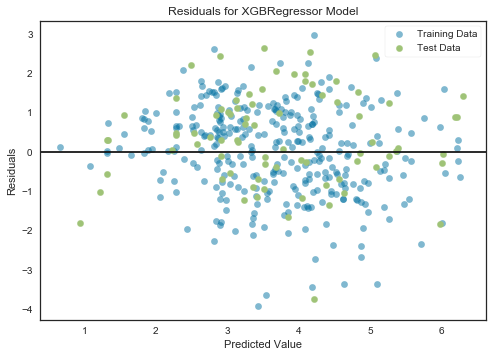

In [27]:
visualizer = ResidualsPlot(xgd_final)

visualizer.fit(X_train.values, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test.values, y_test)  # Evaluate the model on the test data
g = visualizer.poof()